# Using the Fixed Variance process
The `FixedVariance` volatility process can be used to implement zig-zag model 
estimation where two steps are repeated until convergence.  This can be used 
to estimate models which may not be easy to estimate as a single process due
to numerical issues or a high-dimensional parameter space.

_This setup code is required to run in an IPython notebook_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

### Setup

Imports used in this example.

In [2]:
import datetime as dt

import numpy as np

## Data
The VIX index will be used to illustrate the use of the `FixedVariance` process.  The data is from FRED and is provided by the `arch` package.

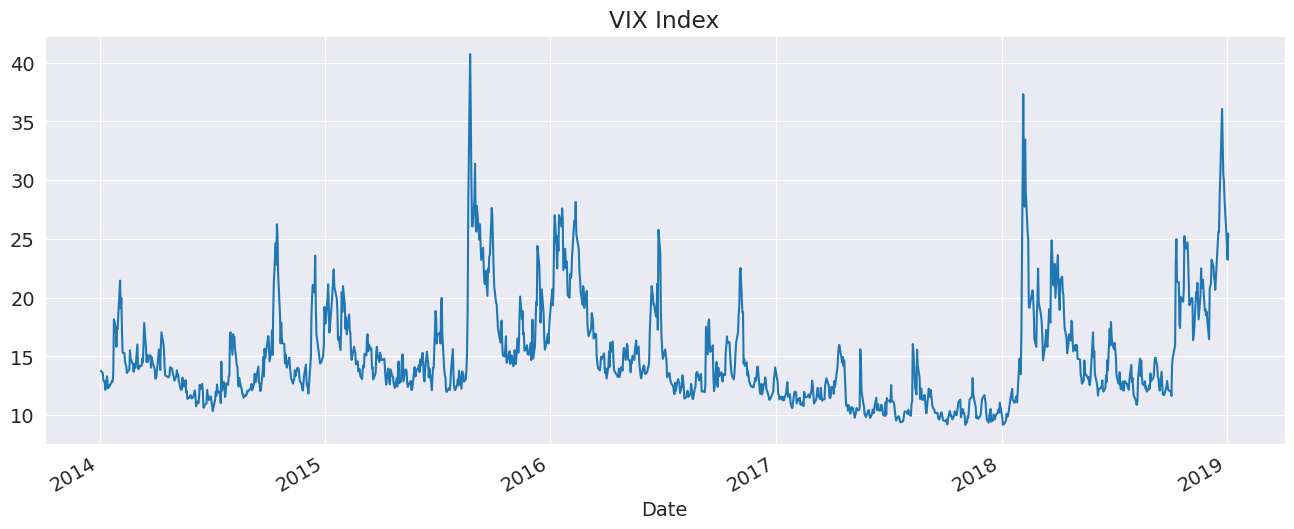

In [3]:
import arch.data.vix

vix_data = arch.data.vix.load()
vix = vix_data.vix.dropna()
vix.name = "VIX Index"
ax = vix.plot(title="VIX Index")

## Initial Mean Model Estimation
The first step is to estimate the mean to filter the residuals using a constant variance. 

In [4]:
from arch.univariate.mean import HARX, ZeroMean
from arch.univariate.volatility import GARCH, FixedVariance

mod = HARX(vix, lags=[1, 5, 22])
res = mod.fit()
print(res.summary())

                    HAR - Constant Variance Model Results                     
Dep. Variable:              VIX Index   R-squared:                       0.876
Mean Model:                       HAR   Adj. R-squared:                  0.876
Vol Model:          Constant Variance   Log-Likelihood:               -2267.95
Distribution:                  Normal   AIC:                           4545.90
Method:            Maximum Likelihood   BIC:                           4571.50
                                        No. Observations:                 1237
Date:                Mon, May 22 2023   Df Residuals:                     1233
Time:                        11:54:12   Df Model:                            4
                                   Mean Model                                   
                      coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------------------------------------------------
Const               0.6335      0.189      3.3

## Initial Volatility Model Estimation
Using the previously estimated residuals, a volatility model can be estimated using a `ZeroMean`. In this example, a GJR-GARCH process is used for the variance.

In [5]:
vol_mod = ZeroMean(res.resid.dropna(), volatility=GARCH(p=1, o=1, q=1))
vol_res = vol_mod.fit(disp="off")
print(vol_res.summary())

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  resid   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1936.93
Distribution:                  Normal   AIC:                           3881.86
Method:            Maximum Likelihood   BIC:                           3902.35
                                        No. Observations:                 1237
Date:                Mon, May 22 2023   Df Residuals:                     1237
Time:                        11:54:12   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2355  9.134e-02      2.578  9.932e-03  [5.64

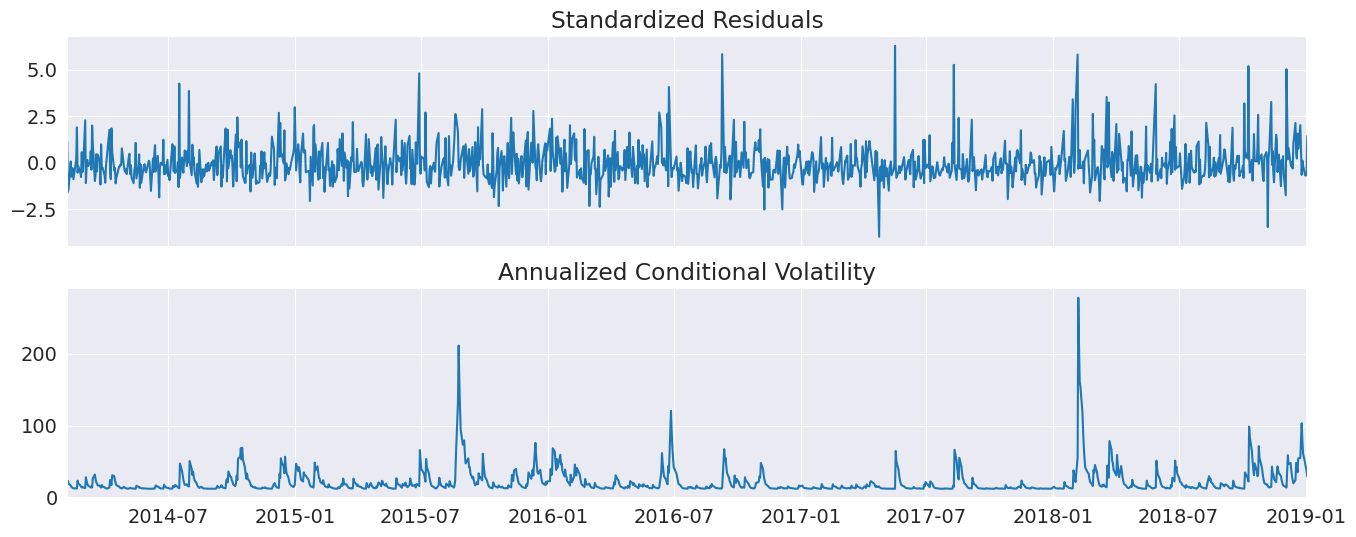

In [6]:
ax = vol_res.plot("D")

## Re-estimating the mean with a ``FixedVariance``
The `FixedVariance` requires that the variance is provided when initializing the object.  The variance provided should have the same shape as the original data.  Since the variance estimated from the GJR-GARCH model is missing the first 22 observations due to the HAR lags, we simply fill these with 1.  These values will not be used to estimate the model, and so the value is not important. 

The summary shows that there is a single parameter, ``scale``, which is close to 1. The mean parameters
have changed which reflects the GLS-like weighting that this re-estimation imposes.

In [7]:
variance = np.empty_like(vix)
variance.fill(1.0)
variance[22:] = vol_res.conditional_volatility**2.0
fv = FixedVariance(variance)
mod = HARX(vix, lags=[1, 5, 22], volatility=fv)
res = mod.fit()
print(res.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 255813245019.088
Iteration:      2,   Func. Count:     19,   Neg. LLF: 930291.9264107295
Iteration:      3,   Func. Count:     28,   Neg. LLF: 3486.6798195388146
Iteration:      4,   Func. Count:     36,   Neg. LLF: 2885.7035662797234
Iteration:      5,   Func. Count:     44,   Neg. LLF: 65535916.590182975
Iteration:      6,   Func. Count:     53,   Neg. LLF: 1935.9527546214572
Iteration:      7,   Func. Count:     59,   Neg. LLF: 1935.9470520474433
Iteration:      8,   Func. Count:     65,   Neg. LLF: 1935.9470514368204
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1935.9470514368204
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
                      HAR - Fixed Variance Model Results                      
Dep. Variable:              VIX Index   R-squared:                       0.876
Mean Model:                       HAR   Adj. R-square

## Zig-Zag estimation
A small repetitions of the previous two steps can be used to implement a so-called zig-zag estimation strategy.

In [8]:
for i in range(5):
    print(i)
    vol_mod = ZeroMean(res.resid.dropna(), volatility=GARCH(p=1, o=1, q=1))
    vol_res = vol_mod.fit(disp="off")
    variance[22:] = vol_res.conditional_volatility**2.0
    fv = FixedVariance(variance, unit_scale=True)
    mod = HARX(vix, lags=[1, 5, 22], volatility=fv)
    res = mod.fit(disp="off")
print(res.summary())

0
1
2
3


4


                    HAR - Fixed Variance (Unit Scale) Model Results                    
Dep. Variable:                       VIX Index   R-squared:                       0.876
Mean Model:                                HAR   Adj. R-squared:                  0.876
Vol Model:         Fixed Variance (Unit Scale)   Log-Likelihood:               -1935.74
Distribution:                           Normal   AIC:                           3879.48
Method:                     Maximum Likelihood   BIC:                           3899.96
                                                 No. Observations:                 1237
Date:                         Mon, May 22 2023   Df Residuals:                     1233
Time:                                 11:54:13   Df Model:                            4
                                    Mean Model                                   
                      coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------

## Direct Estimation
This model can be directly estimated.  The results are provided for comparison to the previous 
``FixedVariance`` estimates of the mean parameters.

In [9]:
mod = HARX(vix, lags=[1, 5, 22], volatility=GARCH(1, 1, 1))
res = mod.fit(disp="off")
print(res.summary())

                        HAR - GJR-GARCH Model Results                         
Dep. Variable:              VIX Index   R-squared:                       0.876
Mean Model:                       HAR   Adj. R-squared:                  0.875
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1932.61
Distribution:                  Normal   AIC:                           3881.23
Method:            Maximum Likelihood   BIC:                           3922.19
                                        No. Observations:                 1237
Date:                Mon, May 22 2023   Df Residuals:                     1233
Time:                        11:54:13   Df Model:                            4
                                   Mean Model                                   
                      coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------------------------------------------------
Const               0.7796      1.190      0.6